In [ ]:
#hide
#skip
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

In [ ]:
#default_exp callback.data

# Data Callbacks

> Callbacks which work with a learner's data

In [ ]:
#export
from fastai.basics import *

In [ ]:
#hide
from nbdev.showdoc import *
from fastai.test_utils import *

In [ ]:
#export
class CollectDataCallback(Callback):
    "Collect all batches, along with `pred` and `loss`, into `self.data`. Mainly for testing"
    def before_fit(self): self.data = L()
    def after_batch(self): 
        self.data.append(self.learn.to_detach((self.xb,self.yb,self.pred,self.loss)))


In [ ]:
# export
class CudaCallback(Callback):
    "Move data to CUDA device"
    def __init__(self, device=None): self.device = ifnone(device, default_device())
    def before_batch(self): self.learn.xb,self.learn.yb = to_device(self.xb),to_device(self.yb)
    def before_fit(self): self.model.to(self.device)

You don't normally need to use this Callback, because fastai's `DataLoader` will handle passing data to a device for you. However, if you already have a plain PyTorch DataLoader and can't change it for some reason, you can use this transform.

In [ ]:
#cuda
learn = synth_learner(cbs=CudaCallback)
learn.model
learn.fit(1)
test_eq(next(learn.model.parameters()).device.type, 'cuda')

[0, 14.484489440917969, 14.21982192993164, '00:00']


In [ ]:
#export
@delegates()
class WeightedDL(TfmdDL):
    def __init__(self, dataset=None, bs=None, wgts=None, **kwargs):
        super().__init__(dataset=dataset, bs=bs, **kwargs)
        wgts = array([1.]*len(dataset) if wgts is None else wgts)
        self.wgts = wgts/wgts.sum()

    def get_idxs(self):
        if self.n==0: return []
        if not self.shuffle: return super().get_idxs()
        return list(np.random.choice(self.n, self.n, p=self.wgts))

In [ ]:
#export
@patch
@delegates(Datasets.dataloaders)
def weighted_dataloaders(self:Datasets, wgts, bs=64, **kwargs):
    xtra_kwargs = [{}] * (self.n_subsets-1)
    return self.dataloaders(bs=bs, dl_type=WeightedDL, dl_kwargs=({'wgts':wgts}, *xtra_kwargs), **kwargs)

In [ ]:
n = 160
dsets = Datasets(torch.arange(n).float())
dls = dsets.weighted_dataloaders(wgts=range(n), bs=16)
learn = synth_learner(data=dls, cbs=CollectDataCallback)

[0, nan, None, '00:01']


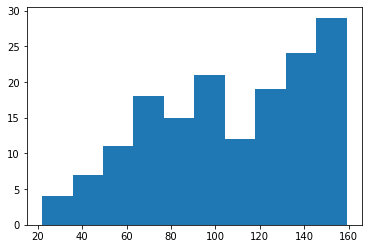

In [ ]:
learn.fit(1)
t = concat(*learn.collect_data.data.itemgot(0,0))
plt.hist(t.numpy());

In [ ]:
#export
@delegates()
class PartialDL(TfmdDL):
    "Select randomly partial quantity of data at each epoch"
    def __init__(self, dataset=None, bs=None, partial_n=None, **kwargs):
        super().__init__(dataset=dataset, bs=bs, **kwargs)
        self.partial_n = min(partial_n, self.n) if partial_n else None

    def get_idxs(self):
        if self.partial_n is None: return super().get_idxs()
        return list(np.random.choice(self.n, self.partial_n, replace=False))

    def __len__(self):
        if self.partial_n is None: return super().__len__()
        return self.partial_n//self.bs + (0 if self.drop_last or self.partial_n%self.bs==0 else 1)

In [ ]:
#export
@patch
@delegates(Datasets.dataloaders)
def partial_dataloaders(self:FilteredBase, partial_n, bs=64, **kwargs):
    "Create a partial dataloader `PartialDL` for the training set"
    xtra_kwargs = [{}] * (self.n_subsets-1)
    return self.dataloaders(bs=bs, dl_type=PartialDL, dl_kwargs=({'partial_n':partial_n}, *xtra_kwargs), **kwargs)

In [ ]:
dls = dsets.partial_dataloaders(partial_n=32, bs=16)

In [ ]:
assert len(dls[0])==2
for batch in dls[0]:
    assert len(batch[0])==16

## Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_torch_core.ipynb.
Converted 01_layers.ipynb.
Converted 01a_losses.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 04_data.external.ipynb.
Converted 05_data.transforms.ipynb.
Converted 06_data.block.ipynb.
Converted 07_vision.core.ipynb.
Converted 08_vision.data.ipynb.
Converted 09_vision.augment.ipynb.
Converted 09b_vision.utils.ipynb.
Converted 09c_vision.widgets.ipynb.
Converted 10_tutorial.pets.ipynb.
Converted 10b_tutorial.albumentations.ipynb.
Converted 11_vision.models.xresnet.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_callback.core.ipynb.
Converted 13a_learner.ipynb.
Converted 13b_metrics.ipynb.
Converted 14_callback.schedule.ipynb.
Converted 14a_callback.data.ipynb.
Converted 15_callback.hook.ipynb.
Converted 15a_vision.models.unet.ipynb.
Converted 16_callback.progress.ipynb.
Converted 17_callback.tracker.ipynb.
Converted 18_callback.fp16.ipynb.
Converted 18a_callback.training.ipynb.
Converted 18b_callback.preds.ipynb.
Converted 